### TODO
- 0: create google sheet with data and merge by eye duplications that are split by tool
- 1: RNAseq windows
    - 200kb windows increasing 20kb at a time (try different window sizes)
    - get fraction of positives
    - t-test this window against all others for a given pval
    - plot all the windows that fail the null hypothesis on the positive side
    - plot all the windows that fail the null hypothesis on the negative side (control)
- 2: RNAseq diff expression
    - plot all genes as black dots
    - plot all genes that are diff expressed
- 3: scatter plots:
    - number of duplications of gene vs log fold change (for all mutants and for each mutant separately)
    - log fold change of genes in small duplication vs large duplication (0-500KB; 500KB-1MB; 1MB+)
- 4: paired-end data and split reads for determining where duplications go
- 5: after having the locations of the copy's and deletions, get data from paper that says the percentage of the celegans genome that is CNV (I think it's 5% and it's mostly deletions) and match our CNVs whith their's. Analyse the match. Do all of the paper's CNVs show up in our data? we should have extra CNV's from the mutation

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [11]:
def get_data(mut, ignore_duplicates=True):
    suf = '.sorted.ignore.bedgraph' if ignore_duplicates else '.sorted.bedgraph'
    path = '../results/bedgraphs/' + mut + suf 
    return pd.read_csv(path, sep='\t', header=0, names=['chr', 'start', 'end', 'log2'])

In [12]:
def get_peaks(exp, threshold=1e-8, chro='CHROMOSOME_X'):
    f = '../results/peaks/' + exp + '.peaks.txt'
    names = ["type", "coordinates", "size", "normalized_RD", "eval1", "eval2", "eval3", "eval4", "q0"]
    df = pd.read_csv(f, sep='\t', names=names)
    chr_re = re.compile(r'CHROMOSOME_(I|II|III|IV|V|X)(?=:)')
    df['chr'] = df['coordinates'].apply(lambda x: chr_re.match(x).group() if chr_re.match(x) else 'Mt')
    df_chr = df[df['chr'] == chro]
    return df_chr[df_chr['eval1'] < threshold]

In [13]:
def get_binned_log_change_zscores(mut, stage, bin_size=200000):
    try:
        df = pd.read_csv(f'../results/deseq/{mut}_{stage}/results/N2vs{mut}.deseq.txt', sep='\t')
    except FileNotFoundError:
        df = pd.read_csv(f'../results/deseq/{mut}_{stage}/results/{mut}vsN2.deseq.txt', sep='\t')
    gene_annots = pd.read_csv('../annots/c.elegans.WS220.gene.wbid.chr.start.stop.txt', sep='\t', index_col=0)
    merged = df.join(gene_annots, how='inner')
    merged.loc[:, 'bin_ix'] = merged.loc[:, 'start'] // bin_size
    f_pos = lambda x: np.sum(x > 0) / float(len(x))
    f_neg = lambda x: np.sum(x < 0) / float(len(x))
    grouped_pos = (merged[['log2FoldChange', 'chr', 'bin_ix']]
                   .groupby(['chr', 'bin_ix'])
                   .agg({f_pos})['log2FoldChange']
                   .rename(columns={'<lambda>': 'pos_zscore'}))
    grouped_neg = (merged[['log2FoldChange', 'chr', 'bin_ix']]
                   .groupby(['chr', 'bin_ix'])
                   .agg({f_neg})['log2FoldChange']
                   .rename(columns={'<lambda>': 'neg_zscore'}))
    grouped = grouped_pos.join(grouped_neg,how='inner').reset_index()
    assert(grouped_pos.shape[0] == grouped_neg.shape[0] == grouped.shape[0])
    return grouped

In [16]:
def plot_coverage(mut, chro, start, end, figsize=(15,10)):
    '''
    '''
    df = get_data(mut)
    cnvs = get_peaks(mut, chro=chro, threshold=1e-3)
    fig, ax1 = plt.subplots(1,1, sharex=True, figsize=figsize)
    
    df.loc[:, 'score'] = (df['log2'] - df['log2'].mean()) / df['log2'].std()
    df_chr = df[df['chr'] == chro]
    df_sub = df_chr[(df_chr['start'] > start) & (df_chr['start'] < end)]
    
    coord_re = re.compile('([0-9]+)-([0-9]+)')
    for ix, cnv in cnvs.iterrows():
        m = coord_re.search(cnv['coordinates'])
        st = int(m.group(1))
        e = int(m.group(2))
        if st > start and st < end:
            ax1.axvline(x=st, c='b', ls='dashed', fillstyle='none', lw=1)
        if e > start and e < end:
            ax1.axvline(x=e, c='r', ls='dotted', lw=4)
            
    ymin = df_sub['score']
    ax1.plot(df_sub['start']+25, df_sub['score'], '.')
    ax1.set_title(f'{mut}:{chro}:{start}-{end}')
    
    if mut in ('bc4289', 'sp117', 'ty1916', 'vc100'):
        binned_deseq = get_binned_log_change_zscores(mut, 'emb', bin_size=200000)
        binned_deseq = binned_deseq[binned_deseq['chr'] == chro]
        x = binned_deseq['bin_ix'] * 200000
        y = np.zeros_like(x)+np.min(df_sub['score'])
        c = binned_deseq['pos_zscore']
        cm = plt.cm.get_cmap('RdYlBu')
        sc = ax1.scatter(x, y, c=c, s=35, cmap=cm)
        plt.colorbar(sc)
    plt.show()
    
    #x = np.arange(10).reshape(1,-1)
    #ax[1].imshow(x, cmap=cm.hot)
    #ax[1].set_xticks(np.linspace(start, end, 10))
    #fig.show()

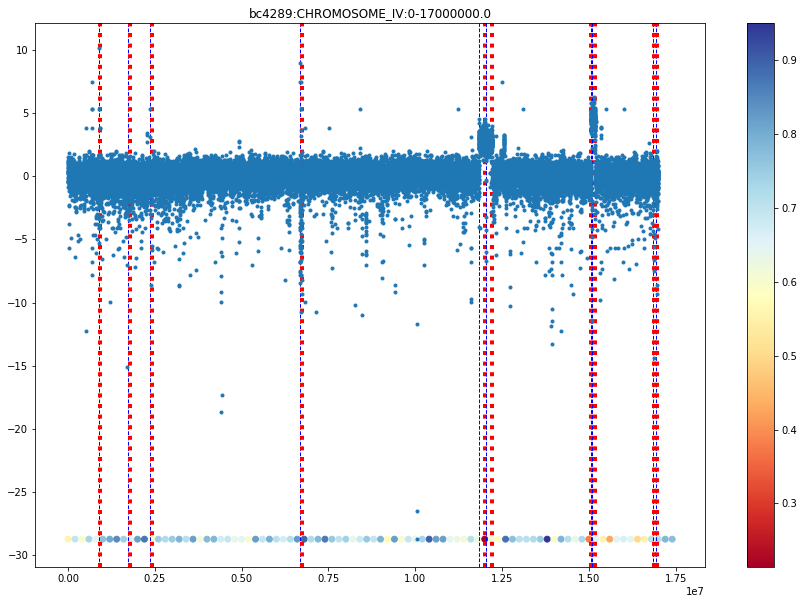

In [17]:
# expected: IV: 5.21M - 8.51M
plot_coverage('bc4289', 'CHROMOSOME_IV', 0, 17e6, (15,10))

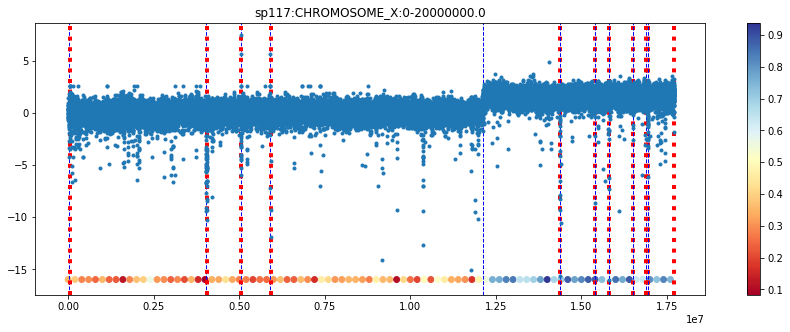

In [18]:
# expected: X: 17.7M - end
plot_coverage('sp117', 'CHROMOSOME_X', 0, 20e6, (15,5))

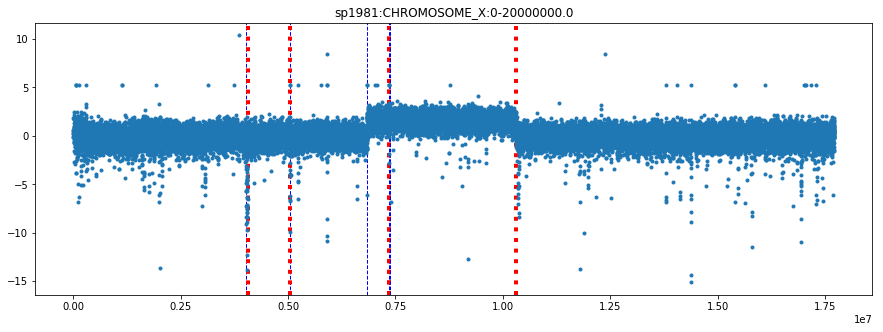

In [19]:
# expected: ?
plot_coverage('sp1981', 'CHROMOSOME_X', 0, 20e6, (15,5))

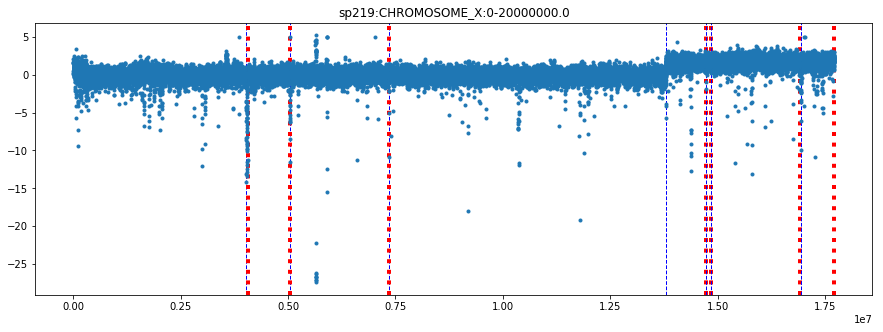

In [20]:
# expected: X: 14.7 - 17.7
plot_coverage('sp219', 'CHROMOSOME_X', 0, 20e6, (15,5))

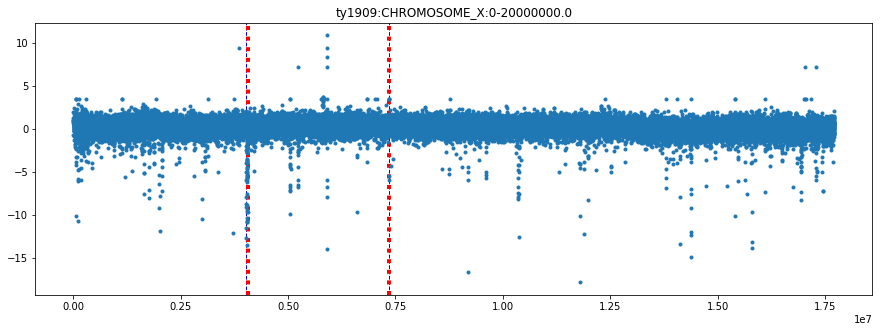

In [21]:
# expected: X: 6.75 - 10.25M
plot_coverage('ty1909', 'CHROMOSOME_X', 0, 20e6, (15,5))

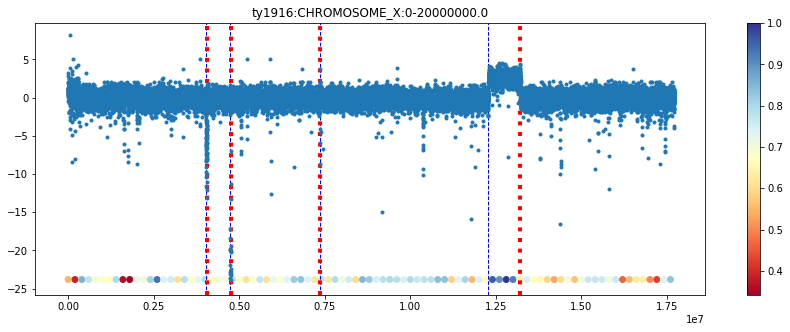

In [22]:
# expected: IV: 7M - 13.6M
plot_coverage('ty1916', 'CHROMOSOME_X', 0, 20e6, (15,5))

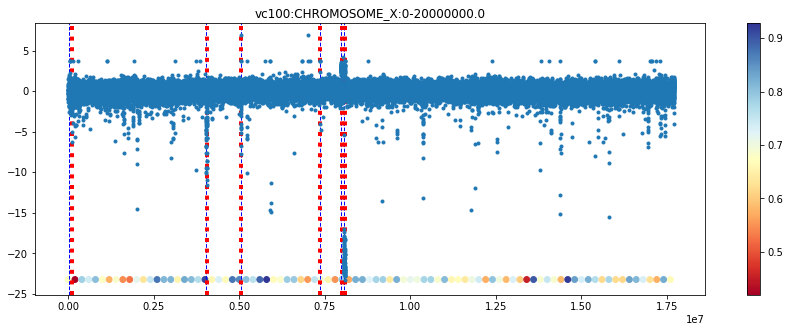

In [23]:
# expected: ?
plot_coverage('vc100', 'CHROMOSOME_X', 0, 20e6, (15,5))